## 封装为函数

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import uav_trajectory

def load_and_filter_trajectories(file_pattern, x_threshold=-0.90):
    """
    Load and filter trajectory data from CSV files.
    
    Args:
        file_pattern (str): Glob pattern for CSV files (e.g., './data/middle/*.csv').
        x_threshold (float): Threshold for filtering x values.
    
    Returns:
        list: Lists of t, x, z arrays for each valid trajectory.
    """
    all_t, all_x, all_z = [], [], []
    
    for csv_file in glob.glob(file_pattern):
        try:
            df = pd.read_csv(csv_file, header=None, skiprows=1)
            t_start = df[0].iloc[-1]
            df = df.iloc[:-1]
            df = df[(df[1] > x_threshold) & (df[0] > t_start)]
            
            if df.empty:
                print(f"{csv_file} -> Empty data, skipping")
                continue
                
            t = df[0].to_numpy() - df[0].iloc[0]  # Align time to 0
            x = df[1].to_numpy()
            z = df[3].to_numpy()
            
            all_t.append(t)
            all_x.append(x)
            all_z.append(z)
            
        except Exception as e:
            print(f"Error processing {csv_file}: {e}")
            continue
            
    return all_t, all_x, all_z

def interpolate_trajectories(all_t, all_x, all_z, num_points=500):
    """
    Interpolate trajectories to a common time grid and compute mean/std.
    
    Args:
        all_t (list): List of time arrays.
        all_x (list): List of x-coordinate arrays.
        all_z (list): List of z-coordinate arrays.
        num_points (int): Number of points for interpolation.
    
    Returns:
        tuple: Common time grid, mean and std for x and z.
    """
    t_min = max(t[0] for t in all_t)
    t_max = min(t[-1] for t in all_t)
    t_common = np.linspace(t_min, t_max, num_points)
    
    x_interp_all = [np.interp(t_common, t, x) for t, x in zip(all_t, all_x)]
    z_interp_all = [np.interp(t_common, t, z) for t, z in zip(all_t, all_z)]
    
    x_interp_all = np.array(x_interp_all)
    z_interp_all = np.array(z_interp_all)
    
    x_mean = np.mean(x_interp_all, axis=0)
    x_std = np.std(x_interp_all, axis=0)
    z_mean = np.mean(z_interp_all, axis=0)
    z_std = np.std(z_interp_all, axis=0)
    
    return t_common, x_mean, x_std, z_mean, z_std



def plot_hangar_box(ax: plt.Axes):
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    ax.plot([x_min, x_max], [z_min, z_min], 'k--', linewidth=0.5, label = 'hangar region')  # Bottom
    ax.plot([x_min, x_max], [z_max, z_max], 'k--', linewidth=0.5)  # Top
    ax.plot([x_min, x_min], [z_min, z_max], 'k--', linewidth=0.5)  # Left
    ax.plot([x_max, x_max], [z_min, z_max], 'k--', linewidth=0.5)  # Right



if __name__ == '__main__':
     
    x_threshold = -0.90
    num_points = 500

    file_folder_high = './data/high/*.csv'
    file_folder_middle = './data/middle/*.csv'
    file_folder_low = './data/low/*.csv'

    # Load and filter trajectories
    all_t_high, all_x_high, all_z_high = load_and_filter_trajectories(file_folder_high, x_threshold)
    all_t_middle, all_x_middle, all_z_middle = load_and_filter_trajectories(file_folder_middle, x_threshold)
    all_t_low, all_x_low, all_z_low = load_and_filter_trajectories(file_folder_low, x_threshold)

    # Interpolate trajectories to a common time grid and compute mean/std
    t_common_high, x_mean_high, x_std_high, z_mean_high, z_std_high = interpolate_trajectories(all_t_high, all_x_high, all_z_high, num_points)
    t_common_middle, x_mean_middle, x_std_middle, z_mean_middle, z_std_middle = interpolate_trajectories(all_t_middle, all_x_middle, all_z_middle, num_points)
    t_common_low, x_mean_low, x_std_low, z_mean_low, z_std_low = interpolate_trajectories(all_t_low, all_x_low, all_z_low, num_points)



    fig, axs = plt.subplots(2, 3, figsize = (15,6))


    # =======================================================
    # High 
    # =======================================================

    axs[0,0].plot(x_mean_high, z_mean_high, color='g', label='Mean Real Trajectory', linewidth=0.5)
    axs[0,0].fill_between(x_mean_high, z_mean_high - z_std_high, z_mean_high + z_std_high, color='red', alpha=0.15, label='Mean ± 1 Std')

    # # Plot waypoints
    # waypoints_path = "./data/waypoints/final_high.csv"
    # waypoints = np.loadtxt(waypoints_path, delimiter=",")
    # mask = waypoints[:, 0] > x_threshold
    # axs[0,0].scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=10)

    # # Plot commanded trajectory
    # traj = uav_trajectory.Trajectory()
    # trajectory_path = "./data/trajectories/final_high_traj.csv"
    # traj.loadcsv(trajectory_path)
    # ts = np.arange(0, traj.duration, 0.01)
    # evals = np.empty((len(ts), 15))
    # for t, i in zip(ts, range(0, len(ts))):
    #     e = traj.eval(t)
    #     evals[i, 0:3] = e.pos
    #     evals[i, 3:6] = e.vel
    #     evals[i, 6:9] = e.acc
    #     evals[i, 9:12] = e.omega
    #     evals[i, 12] = e.yaw
    #     evals[i, 13] = e.roll
    #     evals[i, 14] = e.pitch
    # mask = evals[:, 0] > x_threshold
    # axs[0,0].plot(evals[mask, 0], evals[mask, 2], label="Commanded Trajectory", color='green', linewidth=0.5)


    # # Plot desired trajectory
    # traj = uav_trajectory.Trajectory()
    # trajectory_path = "./data/trajectories/comd_high_traj.csv"
    # traj.loadcsv(trajectory_path)
    # ts = np.arange(0, traj.duration, 0.01)
    # evals = np.empty((len(ts), 15))
    # for t, i in zip(ts, range(0, len(ts))):
    #     e = traj.eval(t)
    #     evals[i, 0:3] = e.pos
    #     evals[i, 3:6] = e.vel
    #     evals[i, 6:9] = e.acc
    #     evals[i, 9:12] = e.omega
    #     evals[i, 12] = e.yaw
    #     evals[i, 13] = e.roll
    #     evals[i, 14] = e.pitch
    # mask = evals[:, 0] > x_threshold
    # axs[0,0].plot(evals[mask, 0], evals[mask, 2], label="Desired Trajectory", color='blue', linewidth=0.5)

    axs[0,0].set_title('High')
    axs[0,0].set_xlabel('x')
    axs[0,0].set_ylabel('z')
    axs[0,0].grid(True)
    axs[0,0].set_xlim(-1.0, 0.5)
    axs[0,0].set_ylim(0.5, 1.1)
    # axs[0,0].legend(loc='upper right')
    # axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(axs[0,0])
    axs[0,0].set_aspect('equal')
    axs[0,0].set_xticks(np.arange(-1.0, 0.6, 0.5))
    axs[0,0].set_yticks(np.arange(0.5, 1.1, 0.25))
    # # axs[0,0].set_aspect('equal', 'box')

 
    # =======================================================
    # Middle
    # =======================================================

    axs[0,1].plot(x_mean_middle, z_mean_middle, color='g', label='Mean Real Trajectory', linewidth=0.5) 
    axs[0,1].fill_between(x_mean_middle, z_mean_middle - z_std_middle, z_mean_middle + z_std_middle, color='red', alpha=0.15, label='Mean ± 1 Std')

    # # Plot waypoints
    # waypoints_path = "./data/waypoints/final_middle.csv"
    # waypoints = np.loadtxt(waypoints_path, delimiter=",")
    # mask = waypoints[:, 0] > x_threshold
    # axs[0,1].scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=10)

    # # Plot commanded trajectory
    # traj = uav_trajectory.Trajectory()
    # trajectory_path = "./data/trajectories/final_middle_traj.csv"
    # traj.loadcsv(trajectory_path)
    # ts = np.arange(0, traj.duration, 0.01)
    # evals = np.empty((len(ts), 15))
    # for t, i in zip(ts, range(0, len(ts))):
    #     e = traj.eval(t)
    #     evals[i, 0:3] = e.pos
    #     evals[i, 3:6] = e.vel
    #     evals[i, 6:9] = e.acc
    #     evals[i, 9:12] = e.omega
    #     evals[i, 12] = e.yaw
    #     evals[i, 13] = e.roll
    #     evals[i, 14] = e.pitch
    # mask = evals[:, 0] > x_threshold
    # axs[0,1].plot(evals[mask, 0], evals[mask, 2], label="Commanded Trajectory", color='green', linewidth=0.5)


    # # Plot desired trajectory
    # traj = uav_trajectory.Trajectory()
    # trajectory_path = "./data/trajectories/comd_middle_traj.csv"
    # traj.loadcsv(trajectory_path)
    # ts = np.arange(0, traj.duration, 0.01)
    # evals = np.empty((len(ts), 15))
    # for t, i in zip(ts, range(0, len(ts))):
    #     e = traj.eval(t)
    #     evals[i, 0:3] = e.pos
    #     evals[i, 3:6] = e.vel
    #     evals[i, 6:9] = e.acc
    #     evals[i, 9:12] = e.omega
    #     evals[i, 12] = e.yaw
    #     evals[i, 13] = e.roll
    #     evals[i, 14] = e.pitch
    # mask = evals[:, 0] > x_threshold
    # axs[0,1].plot(evals[mask, 0], evals[mask, 2], label="Desired Trajectory", color='blue', linewidth=0.5)
    
    axs[0,1].set_title('Middle')
    axs[0,1].set_xlabel('x')
    axs[0,1].grid(True)
    axs[0,1].set_xlim(-1.0, 0.5)
    axs[0,1].set_ylim(0.5, 1.1)
    # axs[0,1].legend(loc='upper right')
    # axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(axs[0,1])
    axs[0,1].set_aspect('equal')
    axs[0,1].set_xticks(np.arange(-1.0, 0.6, 0.5))
    axs[0,1].set_yticks(np.arange(0.5, 1.1, 0.25))
    # axs[0,1].set_aspect('equal', 'box')


    # =======================================================
    # Low
    # =======================================================

    axs[0,2].plot(x_mean_low, z_mean_low, color='g', label='Mean Real Trajectory', linewidth=0.5)
    axs[0,2].fill_between(x_mean_low, z_mean_low - z_std_low, z_mean_low + z_std_low, color='red', alpha=0.15, label='Mean ± 1 Std')

    # # Plot waypoints
    # waypoints_path = "./data/waypoints/final_low.csv"
    # waypoints = np.loadtxt(waypoints_path, delimiter=",")
    # mask = waypoints[:, 0] > x_threshold
    # axs[0,2].scatter(waypoints[mask, 0], waypoints[mask, 2], c="red", marker="o", s=10)

    # # Plot commanded trajectory
    # traj = uav_trajectory.Trajectory()
    # trajectory_path = "./data/trajectories/final_low_traj.csv"
    # traj.loadcsv(trajectory_path)
    # ts = np.arange(0, traj.duration, 0.01)
    # evals = np.empty((len(ts), 15))
    # for t, i in zip(ts, range(0, len(ts))):
    #     e = traj.eval(t)
    #     evals[i, 0:3] = e.pos
    #     evals[i, 3:6] = e.vel
    #     evals[i, 6:9] = e.acc
    #     evals[i, 9:12] = e.omega
    #     evals[i, 12] = e.yaw
    #     evals[i, 13] = e.roll
    #     evals[i, 14] = e.pitch
    # mask = evals[:, 0] > x_threshold
    # axs[0,2].plot(evals[mask, 0], evals[mask, 2], label="Commanded Trajectory", color='green', linewidth=0.5)


    # # Plot desired trajectory
    # traj = uav_trajectory.Trajectory()
    # trajectory_path = "./data/trajectories/comd_low_traj.csv"
    # traj.loadcsv(trajectory_path)
    # ts = np.arange(0, traj.duration, 0.01)
    # evals = np.empty((len(ts), 15))
    # for t, i in zip(ts, range(0, len(ts))):
    #     e = traj.eval(t)
    #     evals[i, 0:3] = e.pos
    #     evals[i, 3:6] = e.vel
    #     evals[i, 6:9] = e.acc
    #     evals[i, 9:12] = e.omega
    #     evals[i, 12] = e.yaw
    #     evals[i, 13] = e.roll
    #     evals[i, 14] = e.pitch
    # mask = evals[:, 0] > x_threshold
    # axs[0,2].plot(evals[mask, 0], evals[mask, 2], label="Desired Trajectory", color='blue', linewidth=0.5)

    axs[0,2].set_title('Low',y = 0.99)
    axs[0,2].set_xlabel('x')
    axs[0,2].grid(True)
    axs[0,2].set_xlim(-1.0, 0.5)
    axs[0,2].set_ylim(0.5, 1.1)  
    # axs[0,2].legend(loc='upper right')
    # axs[0,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=3)
    plot_hangar_box(axs[0,2])
    axs[0,2].set_aspect('equal')
    axs[0,2].set_xticks(np.arange(-1.0, 0.6, 0.5))
    axs[0,2].set_yticks(np.arange(0.5, 1.1, 0.25))
    # axs[0,2].set_aspect('equal', 'box')



    img_paths = ['./data/imgs/high_snapshot.jpg', './data/imgs/middle_snapshot.jpg', './data/imgs/low_snapshot.jpg']  # 替换为你的图片路径
    for i, img_path in enumerate(img_paths):
        img = plt.imread(img_path)
        axs[1, i].imshow(img)
        axs[1, i].axis('off')
        # axs[1, i].set_title(f"Snapshot {i+1}")

    # 只收集第一行轨迹子图的 legend, 对于2行
    handles, labels = [], []
    for ax in axs[0]:  # 只遍历第一行
        for h, l in zip(*ax.get_legend_handles_labels()):
            if l not in labels:
                handles.append(h)
                labels.append(l)

    # 添加全局 legend
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=3)


    # # 收集所有 handles 和 labels 对于1行
    # handles, labels = [], []
    # for ax in axs:
    #     for h, l in zip(*ax.get_legend_handles_labels()):
    #         if l not in labels:
    #             handles.append(h)
    #             labels.append(l)
    
    # # 添加全局 legend
    # fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.92), ncol=3)
    
    # # suptitle 稍微往上移
    # plt.suptitle('Mean and Std of z vs x for Different Trajectory Heights', fontsize=16, y=1.03)
    # plt.tight_layout(rect=[0, 0, 1, 0.90])  # 留出 legend 空间

    # plt.tight_layout()
    # plt.suptitle('Mean and Std of z vs x for Different Trajectory Heights', fontsize=16)
    # plt.subplots_adjust(hspace=0.0,)  # Adjust top to make room for the title
    # plt.show()

    # Save as PDF
    output_file = 'trajectory_plot.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.close()
    print(f"Plot saved to {output_file}")


Plot saved to trajectory_plot.pdf


In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

def load_and_filter_trajectories(file_pattern, x_threshold=-0.90):
    """
    Load and filter trajectory data from CSV files.
    
    Args:
        file_pattern (str): Glob pattern for CSV files (e.g., './data/middle/*.csv').
        x_threshold (float): Threshold for filtering x values.
    
    Returns:
        list: Lists of t, x, z arrays for each valid trajectory.
    """
    all_t, all_x, all_z = [], [], []
    
    for csv_file in glob.glob(file_pattern):
        try:
            df = pd.read_csv(csv_file, header=None, skiprows=1)
            t_start = df[0].iloc[-1]
            df = df.iloc[:-1]
            df = df[(df[1] > x_threshold) & (df[0] > t_start)]
            
            if df.empty:
                print(f"{csv_file} -> Empty data, skipping")
                continue
                
            t = df[0].to_numpy() - df[0].iloc[0]  # Align time to 0
            x = df[1].to_numpy()
            z = df[3].to_numpy()
            
            all_t.append(t)
            all_x.append(x)
            all_z.append(z)
            
        except Exception as e:
            print(f"Error processing {csv_file}: {e}")
            continue
            
    return all_t, all_x, all_z

def interpolate_trajectories(all_t, all_x, all_z, num_points=500):
    """
    Interpolate trajectories to a common time grid and compute mean/std.
    
    Args:
        all_t (list): List of time arrays.
        all_x (list): List of x-coordinate arrays.
        all_z (list): List of z-coordinate arrays.
        num_points (int): Number of points for interpolation.
    
    Returns:
        tuple: Common time grid, mean and std for x and z.
    """
    t_min = max(t[0] for t in all_t)
    t_max = min(t[-1] for t in all_t)
    t_common = np.linspace(t_min, t_max, num_points)
    
    x_interp_all = [np.interp(t_common, t, x) for t, x in zip(all_t, all_x)]
    z_interp_all = [np.interp(t_common, t, z) for t, z in zip(all_t, all_z)]
    
    x_interp_all = np.array(x_interp_all)
    z_interp_all = np.array(z_interp_all)
    
    x_mean = np.mean(x_interp_all, axis=0)
    x_std = np.std(x_interp_all, axis=0)
    z_mean = np.mean(z_interp_all, axis=0)
    z_std = np.std(z_interp_all, axis=0)
    
    return t_common, x_mean, x_std, z_mean, z_std



def plot_hangar_box():
    x_min, x_max = 0.155 - 0.032, 0.377 + 0.032
    z_min, z_max = 0.741, 0.834
    plt.plot([x_min, x_max], [z_min, z_min], 'g-')  # Bottom
    plt.plot([x_min, x_max], [z_max, z_max], 'g-')  # Top
    plt.plot([x_min, x_min], [z_min, z_max], 'g-')  # Left
    plt.plot([x_max, x_max], [z_min, z_max], 'g-')  # Right



if __name__ == '__main__':

    file_pattern = './data/middle/*.csv'
    x_threshold = -0.90
    num_points = 500

    all_t, all_x, all_z = load_and_filter_trajectories(file_pattern, x_threshold)

    t_common, x_mean, x_std, z_mean, z_std = interpolate_trajectories(all_t, all_x, all_z, num_points)

    
    plt.figure(figsize=(7.5, 1))
    plt.rcParams.update({'font.size': 12})  # Set global font size
    plt.plot(x_mean, z_mean, color='green', label='Mean z')
    plt.fill_between(x_mean, z_mean - z_std, z_mean + z_std, color='red', alpha=0.3)
    
    plot_hangar_box()
    
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('x-z Visualization with Mean and Std')
    plt.grid(True)
    plt.xlim(-1.0, 0.5)
    plt.ylim(0.7, 0.9)
    plt.legend(loc = 'upper left')

    output_file = 'trajectory_plot.pdf'
    dpi = 300
    plt.savefig(output_file, format='pdf', dpi=dpi, bbox_inches='tight')
    plt.close()
    print(f"Plot saved to {output_file}")


Plot saved to trajectory_plot.pdf


## Radar Plot

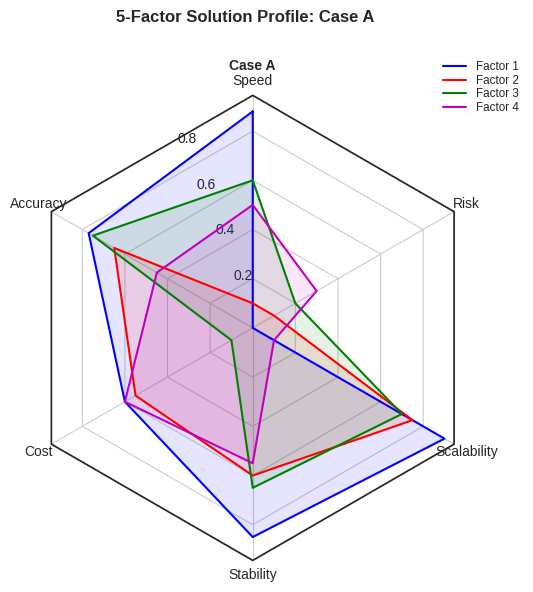

In [29]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections import register_projection
from matplotlib.projections.polar import PolarAxes
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` Axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding Axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


def example_data():
    data = [
        ['Speed', 'Accuracy', 'Cost', 'Stability', 'Scalability', 'Risk'],
        ('Case A', [
            [0.88, 0.77, 0.60, 0.85, 0.90,0.0],
            [0.10, 0.65, 0.55, 0.60, 0.75,0.1],
            [0.60, 0.75, 0.10, 0.65, 0.70,0.2],
            [0.50, 0.45, 0.60, 0.55, 0.10,0.3],
        ])
    ]
    return data

if __name__ == '__main__':

    # 设置角度维度数
    N = 6
    theta = radar_factory(N, frame='polygon')

    # 获取数据
    data = example_data()
    spoke_labels = data.pop(0)

    fig, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1,
                            subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm']
    title, case_data = data[0]
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                horizontalalignment='center', verticalalignment='center')

    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.1, label='_nolegend_')
    ax.set_varlabels(spoke_labels)

    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4')
    ax.legend(labels, loc=(0.9, .95), labelspacing=0.15, fontsize='small')

    plt.suptitle('5-Factor Solution Profile: ' + title, weight='bold', size='large')

    plt.show()

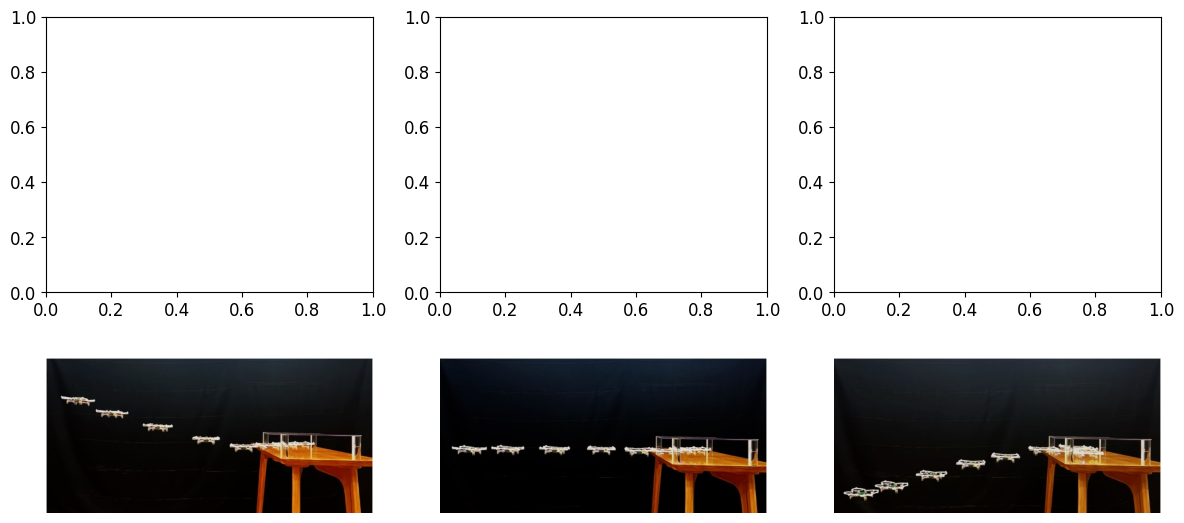

In [80]:
import matplotlib.pyplot as plt
import os

img_paths = ['./data/imgs/high_snapshot.jpg', './data/imgs/middle_snapshot.jpg', './data/imgs/low_snapshot.jpg']
fig, axs = plt.subplots(2, 3, figsize=(12, 6))  # 创建2行3列的子图

for i, img_path in enumerate(img_paths):
    if not os.path.exists(img_path):
        print(f"文件 {img_path} 不存在！")
        continue
    img = plt.imread(img_path)
    axs[1, i].imshow(img)
    axs[1, i].axis('off')  # 关闭坐标轴以美观展示

plt.tight_layout()
plt.show()
